<a href="https://colab.research.google.com/github/garlicxd/Fruit-Classification/blob/automation/Fruit_Classification_Project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Todo
- [ ] patience for training - stopping after no improvement for several epochs
- [ ] create graphs - store information while training
- [ ] compare different optimizers

Using device: cpu
Experiment: baseline_no_augmented_images
Include augmented images: False
Classes to train (30): aloevera, banana, bilimbi, cantaloupe, cassava, coconut, corn, cucumber, curcuma, eggplant, galangal, ginger, guava, kale, longbeans, mango, melon, orange, paddy, papaya, peper chili, pineapple, pomelo, shallot, soybeans, spinach, sweet potatoes, tobacco, waterapple, watermelon
Kaggle API key already configured.
Dataset folder already exists. Skipping download.
Removing existing filtered data directory: ./filtered_data
Creating filtered set at: ./filtered_data/train...
Creating filtered set at: ./filtered_data/val...
Creating filtered set at: ./filtered_data/test...
Class mapping saved to ./class_mapping.json
Data Loaded: Train(2406), Val(314), Test(280)
Starting training...

--- Epoch 1/1 ---


[Train]:   0%|          | 0/76 [00:00<?, ?it/s]

[Validate]:   0%|          | 0/10 [00:00<?, ?it/s]

  Train Loss: 3.2251 | Train Acc: 0.2577
  Val Loss:   3.0047 | Val Acc:   0.5255
  -> New best model found!

Training complete in 12m 40s
Best Val Acc: 0.5255
Best model saved to ./resnet50_baseline_no_augmented_images.pth
--- Running Final Evaluation on Test Set ---


[Test]:   0%|          | 0/9 [00:00<?, ?it/s]


Test Results -> Loss: 3.0096 | Acc: 0.5071
History saved to ./history_baseline_no_augmented_images.json


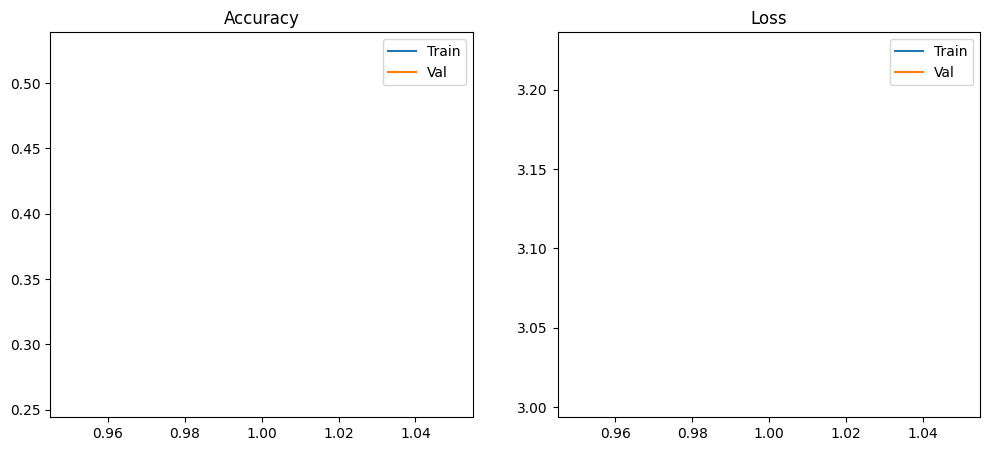

Generating Confusion Matrix...


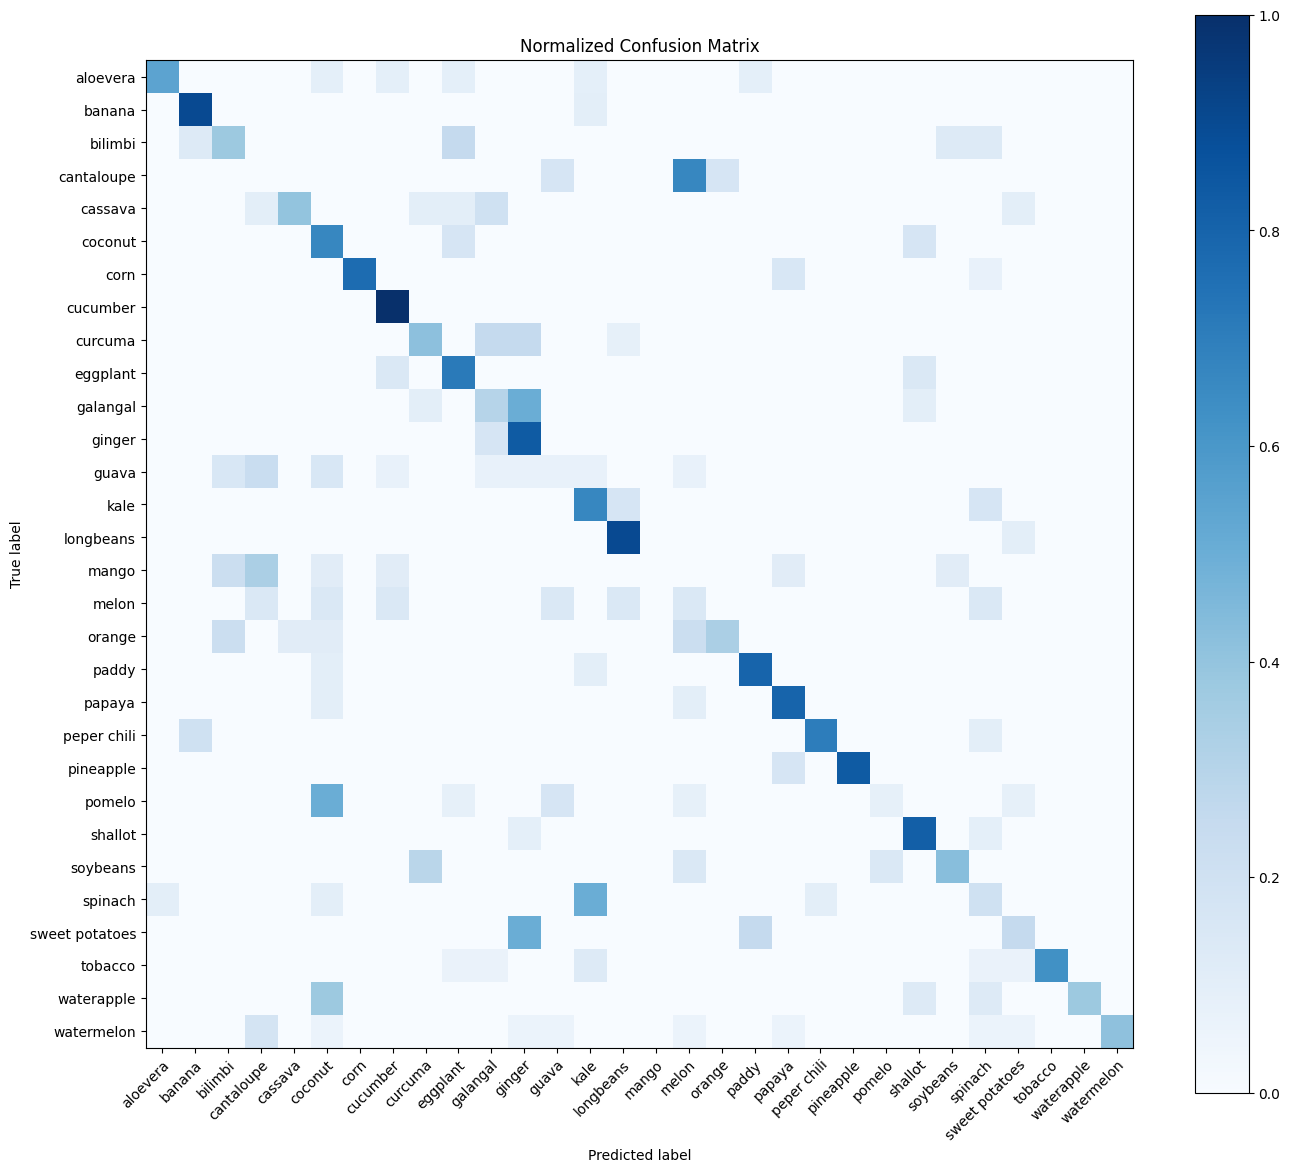


--- Comparative Analysis ---
Baseline Test Acc:  0.5071
Augmented Test Acc: 0.7756


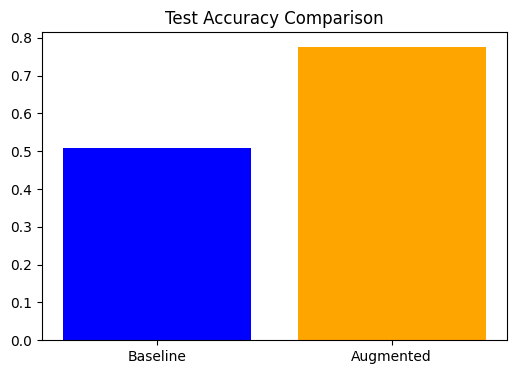

In [2]:
import os
import glob
import shutil
import json
import time
import subprocess
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
import torchvision.models as models
import torchvision.datasets as datasets
import torchvision.transforms as transforms
from tqdm.notebook import tqdm
from sklearn.metrics import confusion_matrix
from google.colab import files  # Keep this if running in Colab

# ==========================================
# 1. Configuration
# ==========================================
class Config:
    def __init__(self):
        # Hardware
        self.DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

        # Dataset Paths
        self.DATASET_FOLDER_PATH = "./split_ttv_dataset_type_of_plants"
        self.BASE_TRAIN_DIR = os.path.join(self.DATASET_FOLDER_PATH, 'Train_Set_Folder')
        self.BASE_VAL_DIR = os.path.join(self.DATASET_FOLDER_PATH, 'Validation_Set_Folder')
        self.BASE_TEST_DIR = os.path.join(self.DATASET_FOLDER_PATH, 'Test_Set_Folder')

        # Filtered Dataset Paths
        self.BASE_FILTERED_DIR = './filtered_data'
        self.FILTERED_TRAIN_DIR = os.path.join(self.BASE_FILTERED_DIR, 'train')
        self.FILTERED_VAL_DIR = os.path.join(self.BASE_FILTERED_DIR, 'val')
        self.FILTERED_TEST_DIR = os.path.join(self.BASE_FILTERED_DIR, 'test')

        # Hyperparameters
        self.IMG_SIZE = (224, 224)
        self.BATCH_SIZE = 32
        self.LEARNING_RATE = 0.01
        self.EPOCHS = 1
        self.MAX_IMAGES_PER_CLASS_TRAIN = 1000
        self.SHUFFLE_TRAINING = True

        # Augmentation Toggle
        self.IMG_AUGMENT = False

        # Experiment Names & Saving
        self.EXPERIMENT_NAME = "with_augmented_images" if self.IMG_AUGMENT else "baseline_no_augmented_images"
        self.MODEL_SAVE_PATH = f'./resnet50_{self.EXPERIMENT_NAME}.pth'
        self.HISTORY_SAVE_PATH = f'./history_{self.EXPERIMENT_NAME}.json'
        self.CLASS_MAP_PATH = './class_mapping.json'

        # Classes
        self.CLASSES_TO_USE = [
            "aloevera", "banana", "bilimbi", "cantaloupe", "cassava", "coconut",
            "corn", "cucumber", "curcuma", "eggplant", "galangal", "ginger",
            "guava", "kale", "longbeans", "mango", "melon", "orange", "paddy",
            "papaya", "peper chili", "pineapple", "pomelo", "shallot", "soybeans",
            "spinach", "sweet potatoes", "tobacco", "waterapple", "watermelon"
        ]
        self.NUM_CLASSES = len(self.CLASSES_TO_USE)

    def print_summary(self):
        print(f"Using device: {self.DEVICE}")
        print(f"Experiment: {self.EXPERIMENT_NAME}")
        print(f"Include augmented images: {self.IMG_AUGMENT}")
        print(f"Classes to train ({self.NUM_CLASSES}): {', '.join(self.CLASSES_TO_USE)}")

# ==========================================
# 2. Data Preparation Functions
# ==========================================
def setup_dataset(config):
    """Downloads and extracts dataset if not present."""
    # Install kaggle if needed
    subprocess.run(["pip", "install", "-q", "kaggle"])

    kaggle_dir = os.path.expanduser("~/.kaggle")
    kaggle_json_path = os.path.join(kaggle_dir, "kaggle.json")

    # Handle API Key
    if not os.path.exists(kaggle_json_path):
        print("kaggle.json not found. Please upload your kaggle.json file:")
        uploaded = files.upload()
        if "kaggle.json" in uploaded:
            os.makedirs(kaggle_dir, exist_ok=True)
            subprocess.run(["cp", "kaggle.json", kaggle_dir])
            subprocess.run(["chmod", "600", kaggle_json_path])
            print("Kaggle API key configured successfully!")
        else:
            print("Upload failed or kaggle.json not found.")
            return
    else:
        print("Kaggle API key already configured.")

    if not os.path.exists(config.DATASET_FOLDER_PATH):
        print(f"Dataset folder '{config.DATASET_FOLDER_PATH}' not found. Downloading...")
        subprocess.run(["kaggle", "datasets", "download", "-d", "yudhaislamisulistya/plants-type-datasets"])
        subprocess.run(["unzip", "-q", "plants-type-datasets.zip"])
        print("Dataset downloaded and unzipped successfully.")
    else:
        print("Dataset folder already exists. Skipping download.")

def create_filtered_subsets(config):
    """Creates a filtered subset of the data based on configuration."""
    if os.path.exists(config.BASE_FILTERED_DIR):
        print(f"Removing existing filtered data directory: {config.BASE_FILTERED_DIR}")
        shutil.rmtree(config.BASE_FILTERED_DIR)

    class_to_idx = {name: i for i, name in enumerate(config.CLASSES_TO_USE)}

    # Helper to process directories
    def process_split(src_base, dst_base, is_train=False):
        print(f"Creating filtered set at: {dst_base}...")
        for class_name in config.CLASSES_TO_USE:
            src_dir = os.path.join(src_base, class_name)
            dst_dir = os.path.join(dst_base, class_name)
            os.makedirs(dst_dir, exist_ok=True)

            all_images = glob.glob(os.path.join(src_dir, '*.*'))

            # Filter based on augmentation setting
            if config.IMG_AUGMENT:
                # Take only augmented images
                imgs = [img for img in all_images if os.path.basename(img).startswith('aug_')]
            else:
                # Take only original images
                imgs = [img for img in all_images if not os.path.basename(img).startswith('aug_')]

            # Apply limit for training set
            if is_train:
                imgs = imgs[:config.MAX_IMAGES_PER_CLASS_TRAIN]

            for img_path in imgs:
                shutil.copy(img_path, dst_dir)

    process_split(config.BASE_TRAIN_DIR, config.FILTERED_TRAIN_DIR, is_train=True)
    process_split(config.BASE_VAL_DIR, config.FILTERED_VAL_DIR)
    process_split(config.BASE_TEST_DIR, config.FILTERED_TEST_DIR)

    with open(config.CLASS_MAP_PATH, 'w') as f:
        json.dump(class_to_idx, f)
    print(f"Class mapping saved to {config.CLASS_MAP_PATH}")

def get_dataloaders(config):
    """Creates DataLoaders for train, val, and test."""
    imgnet_mean = [0.485, 0.456, 0.406]
    imgnet_std = [0.229, 0.224, 0.225]

    data_transforms = {
        'train': transforms.Compose([
            transforms.Resize(config.IMG_SIZE),
            transforms.ToTensor(),
            transforms.Normalize(mean=imgnet_mean, std=imgnet_std)
        ]),
        'val': transforms.Compose([
            transforms.Resize(config.IMG_SIZE),
            transforms.ToTensor(),
            transforms.Normalize(mean=imgnet_mean, std=imgnet_std)
        ]),
        'test': transforms.Compose([
            transforms.Resize(config.IMG_SIZE),
            transforms.ToTensor(),
            transforms.Normalize(mean=imgnet_mean, std=imgnet_std)
        ]),
    }

    image_datasets = {
        'train': datasets.ImageFolder(config.FILTERED_TRAIN_DIR, data_transforms['train']),
        'val': datasets.ImageFolder(config.FILTERED_VAL_DIR, data_transforms['val']),
        'test': datasets.ImageFolder(config.FILTERED_TEST_DIR, data_transforms['test'])
    }

    dataloaders = {
        'train': DataLoader(image_datasets['train'], batch_size=config.BATCH_SIZE, shuffle=config.SHUFFLE_TRAINING),
        'val': DataLoader(image_datasets['val'], batch_size=config.BATCH_SIZE, shuffle=False),
        'test': DataLoader(image_datasets['test'], batch_size=config.BATCH_SIZE, shuffle=False)
    }

    dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val', 'test']}

    print(f"Data Loaded: Train({dataset_sizes['train']}), Val({dataset_sizes['val']}), Test({dataset_sizes['test']})")
    return dataloaders, dataset_sizes

# ==========================================
# 3. Model & Training Functions
# ==========================================
def build_model(config):
    """Initializes ResNet50 with frozen layers and custom head."""
    model = models.resnet50(weights=models.ResNet50_Weights.IMAGENET1K_V2)

    for param in model.parameters():
        param.requires_grad = False

    num_ftrs = model.fc.in_features
    model.fc = nn.Linear(num_ftrs, config.NUM_CLASSES)
    model = model.to(config.DEVICE)
    return model

def train_model(config, model, dataloaders, dataset_sizes):
    """Runs the training loop."""
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.SGD(model.fc.parameters(), lr=config.LEARNING_RATE)

    print("Starting training...")
    start_time = time.time()

    best_model_wts = model.state_dict()
    best_val_acc = 0.0

    history = {"loss": [], "accuracy": [], "val_loss": [], "val_accuracy": []}

    for epoch in range(config.EPOCHS):
        print(f"\n--- Epoch {epoch+1}/{config.EPOCHS} ---")

        # --- Training Phase ---
        model.train()
        running_loss = 0.0
        running_corrects = 0

        progress_bar = tqdm(dataloaders['train'], desc="[Train]")
        for inputs, labels in progress_bar:
            inputs, labels = inputs.to(config.DEVICE), labels.to(config.DEVICE)

            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            _, preds = torch.max(outputs, 1)

            loss.backward()
            optimizer.step()

            running_loss += loss.item() * inputs.size(0)
            running_corrects += torch.sum(preds == labels.data)
            progress_bar.set_postfix(batch_loss=f"{loss.item():.4f}")

        epoch_loss = running_loss / dataset_sizes['train']
        epoch_acc = running_corrects.double() / dataset_sizes['train']

        # --- Validation Phase ---
        model.eval()
        val_running_loss = 0.0
        val_running_corrects = 0

        with torch.no_grad():
            progress_bar_val = tqdm(dataloaders['val'], desc="[Validate]")
            for inputs, labels in progress_bar_val:
                inputs, labels = inputs.to(config.DEVICE), labels.to(config.DEVICE)
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                _, preds = torch.max(outputs, 1)

                val_running_loss += loss.item() * inputs.size(0)
                val_running_corrects += torch.sum(preds == labels.data)

        val_loss = val_running_loss / dataset_sizes['val']
        val_acc = val_running_corrects.double() / dataset_sizes['val']

        print(f"  Train Loss: {epoch_loss:.4f} | Train Acc: {epoch_acc:.4f}")
        print(f"  Val Loss:   {val_loss:.4f} | Val Acc:   {val_acc:.4f}")

        history["loss"].append(epoch_loss)
        history["accuracy"].append(epoch_acc.item())
        history["val_loss"].append(val_loss)
        history["val_accuracy"].append(val_acc.item())

        if val_acc > best_val_acc:
            best_val_acc = val_acc
            best_model_wts = model.state_dict()
            print(f"  -> New best model found!")

    time_elapsed = time.time() - start_time
    print(f"\nTraining complete in {time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s")
    print(f"Best Val Acc: {best_val_acc:.4f}")

    model.load_state_dict(best_model_wts)
    return model, history, best_val_acc

# ==========================================
# 4. Evaluation & Visualization Functions
# ==========================================
def evaluate_on_test(config, model, dataloaders, dataset_sizes):
    """Evaluates the model on the test set."""
    print("--- Running Final Evaluation on Test Set ---")
    criterion = nn.CrossEntropyLoss()
    model.eval()

    test_loss = 0.0
    test_corrects = 0

    with torch.no_grad():
        for inputs, labels in tqdm(dataloaders['test'], desc="[Test]"):
            inputs, labels = inputs.to(config.DEVICE), labels.to(config.DEVICE)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            _, preds = torch.max(outputs, 1)

            test_loss += loss.item() * inputs.size(0)
            test_corrects += torch.sum(preds == labels.data)

    final_loss = test_loss / dataset_sizes['test']
    final_acc = test_corrects.double() / dataset_sizes['test']

    print(f"\nTest Results -> Loss: {final_loss:.4f} | Acc: {final_acc:.4f}")
    return float(final_loss), float(final_acc)

def save_history(config, history, best_val_acc, test_loss, test_acc):
    """Saves training history to JSON."""
    history_data = {
        'loss': [float(x) for x in history['loss']],
        'accuracy': [float(x) for x in history['accuracy']],
        'val_loss': [float(x) for x in history['val_loss']],
        'val_accuracy': [float(x) for x in history['val_accuracy']],
        'experiment_name': config.EXPERIMENT_NAME,
        'img_augment': config.IMG_AUGMENT,
        'epochs': config.EPOCHS,
        'best_val_acc': float(best_val_acc),
        'test_loss': test_loss,
        'test_accuracy': test_acc
    }

    with open(config.HISTORY_SAVE_PATH, 'w') as f:
        json.dump(history_data, f, indent=2)
    print(f"History saved to {config.HISTORY_SAVE_PATH}")

def plot_training_curves(history):
    """Plots accuracy and loss curves."""
    epochs = range(1, len(history['accuracy']) + 1)
    plt.figure(figsize=(12, 5))

    plt.subplot(1, 2, 1)
    plt.plot(epochs, history['accuracy'], label='Train')
    plt.plot(epochs, history['val_accuracy'], label='Val')
    plt.title('Accuracy')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(epochs, history['loss'], label='Train')
    plt.plot(epochs, history['val_loss'], label='Val')
    plt.title('Loss')
    plt.legend()

    plt.show()

def plot_confusion_matrix_vis(config, model, dataloaders):
    """Generates and plots the confusion matrix."""
    model.eval()
    y_true_all = []
    y_pred_all = []

    print("Generating Confusion Matrix...")
    with torch.no_grad():
        for inputs, labels in dataloaders['test']: # Using test set for final CM
            inputs = inputs.to(config.DEVICE)
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            y_true_all.extend(labels.cpu().numpy())
            y_pred_all.extend(preds.cpu().numpy())

    cm = confusion_matrix(y_true_all, y_pred_all)

    # Normalize
    with np.errstate(all='ignore'):
        cm_norm = cm.astype(float) / cm.sum(axis=1, keepdims=True)
        cm_norm = np.nan_to_num(cm_norm)

    # Plot
    fig, ax = plt.subplots(figsize=(14, 12))
    im = ax.imshow(cm_norm, interpolation='nearest', cmap=plt.cm.Blues)
    ax.figure.colorbar(im, ax=ax)

    ax.set(xticks=np.arange(config.NUM_CLASSES),
           yticks=np.arange(config.NUM_CLASSES),
           xticklabels=config.CLASSES_TO_USE,
           yticklabels=config.CLASSES_TO_USE,
           title='Normalized Confusion Matrix',
           ylabel='True label',
           xlabel='Predicted label')

    plt.setp(ax.get_xticklabels(), rotation=45, ha="right", rotation_mode="anchor")
    plt.tight_layout()
    plt.show()

def compare_experiments():
    """Compares baseline and augmented history files if both exist."""
    base_path = './history_baseline_no_augmented_images.json'
    aug_path = './history_with_augmented_images.json'

    if os.path.exists(base_path) and os.path.exists(aug_path):
        print("\n--- Comparative Analysis ---")
        with open(base_path) as f: h_base = json.load(f)
        with open(aug_path) as f: h_aug = json.load(f)

        print(f"Baseline Test Acc:  {h_base.get('test_accuracy', 0):.4f}")
        print(f"Augmented Test Acc: {h_aug.get('test_accuracy', 0):.4f}")

        # Simple bar chart
        plt.figure(figsize=(6, 4))
        plt.bar(['Baseline', 'Augmented'],
                [h_base.get('test_accuracy', 0), h_aug.get('test_accuracy', 0)],
                color=['blue', 'orange'])
        plt.title('Test Accuracy Comparison')
        plt.show()
    else:
        print("\nSkipping comparison (run both experiment types to enable).")

# ==========================================
# 5. Main Execution
# ==========================================
def main():
    # 1. Initialize Configuration
    cfg = Config()
    cfg.print_summary()

    # 2. Setup Data
    setup_dataset(cfg)
    create_filtered_subsets(cfg)
    dataloaders, dataset_sizes = get_dataloaders(cfg)

    # 3. Initialize Model
    model = build_model(cfg)

    # 4. Train
    model, history, best_val_acc = train_model(cfg, model, dataloaders, dataset_sizes)

    # 5. Save Model
    torch.save(model.state_dict(), cfg.MODEL_SAVE_PATH)
    print(f"Best model saved to {cfg.MODEL_SAVE_PATH}")

    # 6. Final Evaluation
    test_loss, test_acc = evaluate_on_test(cfg, model, dataloaders, dataset_sizes)

    # 7. Save History
    save_history(cfg, history, best_val_acc, test_loss, test_acc)

    # 8. Visualization
    plot_training_curves(history)
    plot_confusion_matrix_vis(cfg, model, dataloaders)

    # 9. Comparison (Optional)
    compare_experiments()

if __name__ == "__main__":
    main()